# Import qbiome

In [15]:
import qbiome
from qbiome.data_formatter import DataFormatter
from qbiome.quantizer import Quantizer
from qbiome.qnet_orchestrator import QnetOrchestrator
from qbiome.mask_checker import MaskChecker
from qbiome.forecaster import Forecaster
from qbiome.hypothesis import Hypothesis

In [16]:
from qbiome.qutil import customDataFormatter

# Import other packages

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.style.use('ggplot')

# Data

In [18]:
dirname = 'example_data/'
data = dirname + 'hc_Phylum_GTDB_denoised_filtered_percent.csv'
meta = dirname + 'hc_metadata.csv'

# Instantiate the data formatter, quantizer, qnet orchestrator

In [19]:
data,property_map=customDataFormatter(data,meta,
                        META_PROP=['hc', 'HCZ', 'sex', 'hc_Birth',
           'HCZ_Birth', 'hc_Discharge', 'HCZ_Discharge',
           'HCZ_discharge_birth_difference', 'HCZ_Category',
           'HCZ_difference_Category', 'NEC', 'IVH', 'ROP', 'BPD', 'Infection',
           'total_Morbidities', 'Morbidity_Category', 'TIMPS score',
           'TIMPS z-score', 'TIMPS Category'],
                        COL_SELECT={"Samples": "sample_id", "PTID": "subject_id", "PMA":"week"})

In [20]:
quantizer = Quantizer()
qnet_orchestrator = QnetOrchestrator(quantizer)

# Load, quantize, and convert the data to qnet input format

In [21]:
#data = formatter.load_data(data, meta)
quantized = quantizer.quantize_df(data)
features, label_matrix = quantizer.get_qnet_inputs(quantized)

In [22]:
quantized.head()

,subject_id,Acidobacteriota_24,Acidobacteriota_26,Acidobacteriota_27,Acidobacteriota_28,Acidobacteriota_29,Acidobacteriota_30,Acidobacteriota_31,Acidobacteriota_32,Acidobacteriota_33,...,unclassified_Bacteria_34,unclassified_Bacteria_35,unclassified_Bacteria_36,unclassified_Bacteria_37,unclassified_Bacteria_38,unclassified_Bacteria_39,unclassified_Bacteria_40,unclassified_Bacteria_41,unclassified_Bacteria_42,unclassified_Bacteria_43
0,100001,NaN,NaN,NaN,NaN,NaN,A,A,A,NaN,...,A,A,A,A,NaN,A,A,NaN,NaN,NaN
1,100002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,...,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100003,NaN,NaN,NaN,NaN,A,A,A,A,NaN,...,NaN,NaN,NaN,E,NaN,NaN,NaN,NaN,NaN,NaN
3,100004,NaN,C,A,C,NaN,NaN,A,NaN,NaN,...,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,...,A,NaN,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN


In [23]:
len(features)

532

# Train qnet

In [25]:
# should take < 5 min to run
qnet_orchestrator.train_qnet(
    features, label_matrix, alpha=0.2, min_samples_split=2, 
    out_fname=None)

# Use the mask checker to mask 20% of the label matrix and use qnet to predict

In [26]:
mask_checker = MaskChecker(qnet_orchestrator)

In [27]:
# takes 2 minutes to run
predicted = mask_checker.mask_and_predict(label_matrix, mask_percent=20)

In [28]:
predicted.head()

,subject_id,variable,week,value
0,100001,Acidobacteriota,24,5.421011e-20
1,100002,Acidobacteriota,24,5.421011e-20
2,100003,Acidobacteriota,24,5.421011e-20
3,100004,Acidobacteriota,24,5.421011e-20
4,100005,Acidobacteriota,24,5.421011e-20


# Plot the predicted vs. original biome measurements

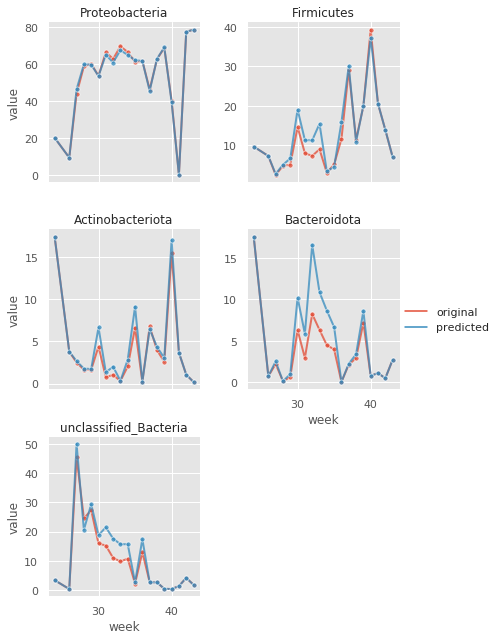

In [33]:
BIOMES = ['Actinobacteriota', 'Bacteroidota', 'Firmicutes', 'Proteobacteria', 'unclassified_Bacteria']

concat = pd.concat([
    data.assign(source='original'), 
    predicted.assign(source='predicted')
])
concat = concat[concat.variable.isin(BIOMES)]

g = sns.FacetGrid(concat, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', hue='source', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

It appears that the prediction passes our eyeball sanity check.

We zoom in to look at the first 20 weeks.

In [34]:
concat

,sample_id,source,subject_id,value,variable,week
3,100001.c.062,original,100001,66.657408,Proteobacteria,34
9,100001.c.062,original,100001,3.005389,Firmicutes,34
12,100001.c.062,original,100001,0.000000,Actinobacteriota,34
14,100001.c.062,original,100001,0.677740,Bacteroidota,34
21,100001.c.062,original,100001,0.000000,unclassified_Bacteria,34
...,...,...,...,...,...,...
20743,NaN,predicted,100078,1.841716,unclassified_Bacteria,43
20744,NaN,predicted,100083,1.812996,unclassified_Bacteria,43
20745,NaN,predicted,100084,1.769917,unclassified_Bacteria,43
20746,NaN,predicted,100090,1.870436,unclassified_Bacteria,43


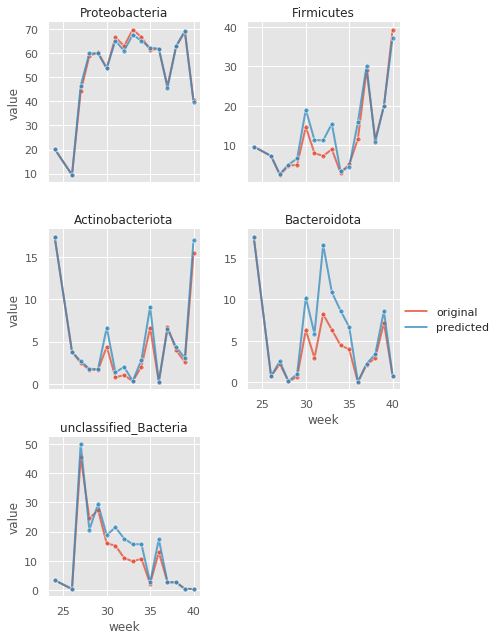

In [35]:
concat = concat[(concat.week <= 40)]

g = sns.FacetGrid(concat, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', hue='source', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

To increase the precision of the prediction, we can apply the random forest regressor in the quantizer. See the example below when we use the forecaster.

# Use the forecaster to sequentially mask part of the original data and predict

In [36]:
forecaster = Forecaster(qnet_orchestrator)

In [37]:
# takes 10 minutes to run
# can specify an end week or default to the max end week in the data
forecasted = forecaster.forecast_data(
    label_matrix, 
    start_week=29,
#     end_week=data.week.max()
)

In [38]:
forecasted.head()

,subject_id,variable,week,value
0,100001,Acidobacteriota,24,NaN
1,100002,Acidobacteriota,24,NaN
2,100003,Acidobacteriota,24,NaN
3,100004,Acidobacteriota,24,NaN
4,100005,Acidobacteriota,24,NaN


## Apply the random forest regressor in the quantizer

In [39]:
dequantized = quantizer.dequantize_to_df(label_matrix)
dequantized_plot = quantizer.melt_into_plot_format(dequantized)
quantizer.fit_random_forest(data, dequantized_plot)

In [40]:
avg_forecasted_regressed = quantizer.apply_random_forest_regressor(
    forecasted)

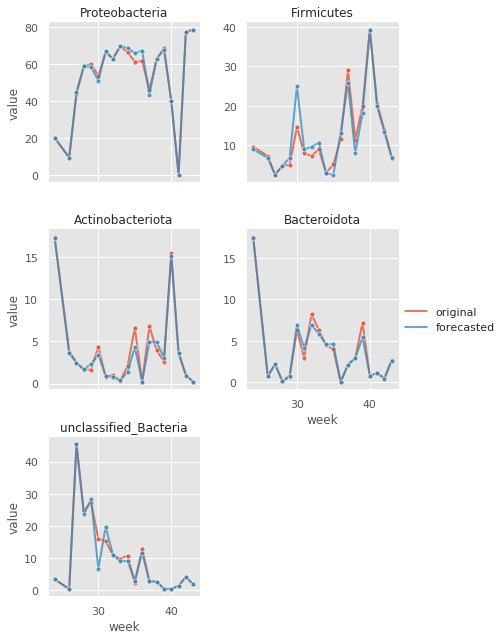

In [41]:
concat = pd.concat([
    data.assign(source='original'), 
    avg_forecasted_regressed.assign(source='forecasted')
])
concat = concat[concat.variable.isin(BIOMES)]
#concat = concat[(concat.week <= 20)]

g = sns.FacetGrid(concat, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', hue='source', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

# Use the forecaster to predict new data

We construct a new patient from the quantized data column names because it contains all the feature names that the qnet uses.

In [42]:
new_subject_id = '101'
np.random.seed(10001)
# initialize with random floats
new_patient = pd.DataFrame(
    np.random.rand(1, len(quantized.columns)),
    index=[0],
    columns=quantized.columns
)
new_patient.subject_id = new_subject_id
new_patient

,subject_id,Acidobacteriota_24,Acidobacteriota_26,Acidobacteriota_27,Acidobacteriota_28,Acidobacteriota_29,Acidobacteriota_30,Acidobacteriota_31,Acidobacteriota_32,Acidobacteriota_33,...,unclassified_Bacteria_34,unclassified_Bacteria_35,unclassified_Bacteria_36,unclassified_Bacteria_37,unclassified_Bacteria_38,unclassified_Bacteria_39,unclassified_Bacteria_40,unclassified_Bacteria_41,unclassified_Bacteria_42,unclassified_Bacteria_43
0,101,0.116507,0.704285,0.523539,0.1577,0.892232,0.694006,0.900454,0.584406,0.305097,...,0.710015,0.071588,0.980152,0.314483,0.696177,0.005446,0.882128,0.221683,0.077481,0.604916


In [43]:
new_patient_seq = new_patient.drop(columns='subject_id').to_numpy().squeeze()
new_patient_seq.shape

(532,)

In [44]:
# suppose we only have 6 weeks of data for the new patient
# we mask out the remainder of the weeks
new_patient_masked = qnet_orchestrator.mask_sequence_at_weeks(
    new_patient_seq, 
    start_week=29, 
    end_week=qnet_orchestrator.get_max_timestamp(),
    fill_value=np.nan
)

In [45]:
new_patient_df = quantizer.add_meta_to_matrix(
    new_patient_masked[np.newaxis, :],
    add_subject_id=False
)
# manually add back subject_id
new_patient_df.insert(0, 'subject_id', [new_subject_id])
new_patient_df

variable,subject_id,Acidobacteriota_24,Acidobacteriota_26,Acidobacteriota_27,Acidobacteriota_28,Acidobacteriota_29,Acidobacteriota_30,Acidobacteriota_31,Acidobacteriota_32,Acidobacteriota_33,...,unclassified_Bacteria_34,unclassified_Bacteria_35,unclassified_Bacteria_36,unclassified_Bacteria_37,unclassified_Bacteria_38,unclassified_Bacteria_39,unclassified_Bacteria_40,unclassified_Bacteria_41,unclassified_Bacteria_42,unclassified_Bacteria_43
0,101,0.116507,0.704285,0.523539,0.1577,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
new_patient_df = quantizer.melt_into_plot_format(new_patient_df)
new_patient_df

,subject_id,variable,week,value
0,101,Acidobacteriota,24,0.116507
1,101,Acidobacteriota,26,0.704285
2,101,Acidobacteriota,27,0.523539
3,101,Acidobacteriota,28,0.157700
4,101,Acidobacteriota,29,NaN
...,...,...,...,...
527,101,unclassified_Bacteria,39,NaN
528,101,unclassified_Bacteria,40,NaN
529,101,unclassified_Bacteria,41,NaN
530,101,unclassified_Bacteria,42,NaN


In [47]:
# quantize
new_patient_quantized = quantizer.quantize_df(new_patient_df)
# convert this patient into a format acceptable by the qnet
_, new_patient_matrix = quantizer.get_qnet_inputs(new_patient_quantized)
new_patient_matrix.shape

(1, 532)

## Forecast the data starting from week 7 to the last week

In [48]:
# takes 2 minutes to run
new_patient_forecasted = forecaster.forecast_data(
    new_patient_matrix, 
    start_week=29
)

In [49]:
new_patient_forecasted.head()

,subject_id,variable,week,value
0,101,Acidobacteriota,24,NaN
1,101,Acidobacteriota,26,NaN
2,101,Acidobacteriota,27,0.321385
3,101,Acidobacteriota,28,NaN
4,101,Acidobacteriota,29,0.501002


The NaNs are due to the random values we generated falling outside the quantization range.

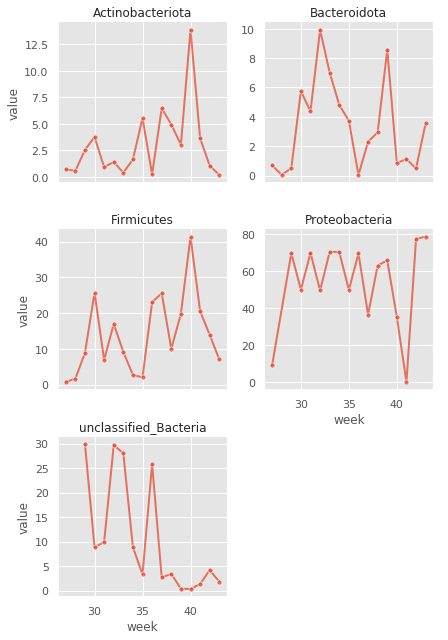

In [50]:
plottable = new_patient_forecasted[new_patient_forecasted.variable.isin(BIOMES)]

g = sns.FacetGrid(plottable, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

In [ ]:
# zoom into the first 20 weeks
plottable = new_patient_forecasted[
    (new_patient_forecasted.variable.isin(BIOMES)) &
    (new_patient_forecasted.week <= 20)
     ]

g = sns.FacetGrid(plottable, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()